# Applications to graph analysis : the PageRank algorithm


This chapter illustrates an application of eigenvalues and eigenvectors to graph analytics with the PageRank algorithm. PageRank is an algorithm that maps a set of web pages to real numbers that can be used to **rank** them.

The algorithm views the web as a graph whose nodes are web pages and whose edges are hyperlinks leading from one page to another. It views the structure of the web graph as a matrix. The algorithm outputs a vector of scores, with one score for each web page and it turns out that the output vector is actually the first eigenvector of the graph adjacency matrix. 


## Representation: the web as a graph

A set of web pages can be represented as a directed graph $G=\langle V, E\rangle$ whose vertices are the actual web pages.
The edges relating the vertices are inferred from hyperlinks: a link sending an internet surfer from page $p_1$ to page $p_2$ is thus an edge $(p_1,p_2) \in E$ of the directed graph.

PageRank is an algorithm that takes advantage of the graph structure to rank the pages rathen than the page contents. It  builds upon the idea
that a web page is important if many pages are pointing to it. In graph terminology we could use the in degree of the nodes to compute their importance. But PageRank goes one step further. It not only counts the incoming edges on the nodes but also weights their importance by the importance of the source node. Thus the page rank is a global computation on the network

```{figure} figs/pr.png
---
height: 250px
name: pagerank-fig
---
The PageRank algorithm weights each node as a function of its incoming edges and the importance of the their source nodes.
```

## Markov chains and random walks

Graphs can be conveniently represented by matrices. 
A graphs's **adjacency matrix** is a matrix   $\mathbf{A}\in \mathbb{R}^{n\times n}$ with $n$ the number of graph vertices. 
A coefficient $a_{ij}$ is set to 1 if there is an edge from node $i$ to node $j$ in the graph and to 0 otherwise.

Here is a sample graph together with its adjacency matrix:

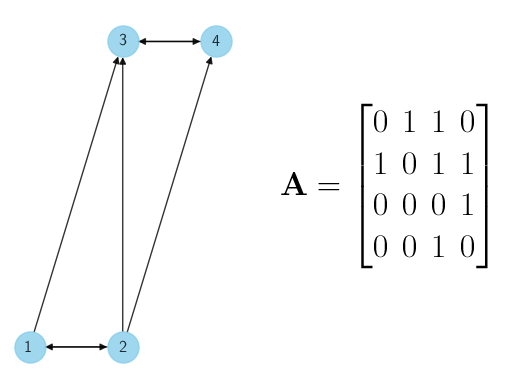

In [1]:
from myst_nb import glue
import networkx as nx
import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{{amsmath}}'

G = nx.DiGraph()
G.add_nodes_from(["1","2","3","4"])
G.add_edge("1","2")
G.add_edge("1","3")
G.add_edge("2","3")
G.add_edge("2","4")
G.add_edge("3","4")
G.add_edge("2","1")
G.add_edge("4","3")

pos = {"1":(0,0),"2":(1,0),"3":(1,1),"4":(2,1)}
fig,ax = plt.subplots(ncols=2)
plt.axis('off')


nx.draw(G,pos=pos,with_labels=True,node_color="skyblue",alpha=0.8,node_size=500,ax=ax[0])

mat = (r"$\mathbf{A} = \begin{bmatrix}0&1&1&0\\1&0&1&1\\0&0&0&1\\0&0&1&0 \end{bmatrix}$")
ax[1].text(0., 0.5, mat, fontsize=24)
glue("stuff", fig, display=False)

each row (or each column) of the matrix represents a source (resp. target) state of the graph.


Given a starting point, a **random walk** on a graph is a succession of moves made randomly by the walker. 
At each step, the random walker has to choose an edge $(i,j)$ among the outgoing edges leaving from the current node $i$ and then ends up 
at node $j$. The choice of the edge is made randomly. A walker in node $i$ moves to node $j$ with probability:

$$
P(j | i) = \frac{1}{\text{outdegree}(i)}
$$

If we let the random walker perform an infinite number of steps, we will be able to count how many times he visits a given node. 
This is the core idea of the PageRank algorithm. The more the random walker visits a node, the more this node is important.
There are a few caveats however: in some graphs, as the one given here, the walker could end up being trapped on some node without any outgoing edge. It may also be the case that a subset of nodes in the graph traps the walker without leaving him the opportunity to leave this particular subset (e.g. cycles without exit). Thus the study of random walks is essentially of interest when the graph is strongly connected, that is there is a path from every node in the graph to every other node in the graph.

We can now formalize this intuitive idea with a particular class of dynamic process called markov chains. 
Given an adjacency matrix, we can turn it into a row stochastic matrix $\mathbf{S}$ by normalizing row counts so that each row
sums to 1. Let $\mathbf{a}_i$ be a row of an adjacency matrix then we build $\mathbf{S}$ as:

$$
P(j|i) = s_{ij} = \frac{a_{ij}}{\sum_j a_{ij}}
$$

```{admonition} Example
:class: tip
For the graph given above we get the row stochastic matrix $\mathbf{S}$ by normalizing the rows of matrix $\mathbf{A}$

$$
\mathbf{S} 
= \begin{bmatrix}
 0&1/2&1/2&0\\
 1/3&0&1/3&1/3\\
 0&0&0&1\\
 0&0&1&0 
 \end{bmatrix}
$$
```


```{admonition} Example (matrix power)
:class: tip
Consider a stochastic vector $\mathbf{x}_0$, assume the values:

$$
\mathbf{M} = \mathbf{S}^\top 
= \begin{bmatrix}
 0  &1/3&0  &0\\
 1/2&0  &0  &0\\
 1/2&1/3& 0 &1\\
 0  &1/3& 1&0 
 \end{bmatrix}\qquad
 \mathbf{x}_0 = 
 \begin{bmatrix}
	1\\0\\0\\0
 \end{bmatrix}
$$

Now observe the effect ot the successive multiplications $\mathbf{x}_{t+1}= \mathbf{M} \mathbf{x}_t$ for the first few values of $t$:

$$
\mathbf{x}_1 =
\begin{bmatrix}
0\\
1/2\\
1/2\\
0
\end{bmatrix}
\quad
\mathbf{x}_2 =
\begin{bmatrix}
1/6\\
0\\
1/6\\
4/6
\end{bmatrix}
\quad
\mathbf{x}_3 =
\begin{bmatrix}
0\\
1/12\\
9/12\\
2/12
\end{bmatrix}
$$

There are a few observations to do here. First at each time step we can observe that the $\mathbf{x}_i$ vector remains stochastic. Second we can interpret the multiplication as providing the probabilities that the walker will end on each state at the next step given the probabilities to be on each state at the current step. Thus the $\mathbf{x}_t$ vector is intepreted as the probability to have the walker on each state after $t$ steps. Finally we can observe that repeated matrix multiplication is matrix power. For instance 

$$
\begin{align}
\mathbf{x}_3 &= \mathbf{M}  \mathbf{M}  \mathbf{M} \mathbf{x}_0\\
&= \mathbf{M}^3 \mathbf{x}_0
\end{align}
$$

In other words, matrix power of stochastic matrices seems to implement a process close to formalizing the PageRank idea given above with $\mathbf{x}_t$ storing the importance of each node as a probability.
```

````{prf:definition} Markov chain
:label: markov chain

A **markov chain** is a sequence of probability vectors $\mathbf{x}_0,\mathbf{x}_1, \mathbf{x}_2\ldots \mathbf{x}_n$ such that 

$$\mathbf{x}_{t+1}=\mathbf{M}\mathbf{x}_t$$

for some column stochastic matrix $\mathbf{M}$. Furthermore a markov chain is **strongly connected** if each state of the stochastic matrix $\mathbf{M}$ is reachable in a finite number of steps from each state of $\mathbf{M}$.
````

````{prf:theorem} Markov chain theorem 
:label: perron-frobenius

If $\mathbf{M}$ is a stochastic matrix with strongly connected graph, then $\mathbf{M}$ has a unique steady-state vector, $\mathbf{x}$. 
Moreover if $\mathbf{x}_0$ is **any** initial probabilistic vector, then

$$
\mathbf{x}_{t+1} = \mathbf{M}\mathbf{x}_t
$$

converges to $\mathbf{x}$ as $t \rightarrow\infty$
````

There are two key observations to do here.  First, {prf:ref}`perron-frobenius` is a theorem than can be read as:
matrix $\mathbf{M}$ is a matrix with eigenvector $\mathbf{x}$ and eigenvalue $\lambda = 1$. 
Indeed the fix point $\mathbf{M}\mathbf{x}_t = \lambda \mathbf{x}_{t+1}$ is just an instanciation of the eigenvector definition with $\lambda = 1$. {prf:ref}`perron-frobenius`
suggests to compute this eigenvector by iterating a very large number of matrix vector multiplications or by computing a matrix power with some high value. **Power iteration** or matrix power is indeed a well known numerical method for computing the first eigenvector of a matrix $\mathbf{M}$.


The second observation relates to the stability of the method. We emphasize that the theorem holds with any initial random vector only if the graph $\mathbf{M}$ is strongly connected. Absence of strong connectivity may have two kind of consequences:

 - The markov chain is **absorbing** : in case a node, or a set of nodes, has not outgoing edge allowing the walker to reach any other node in the graph then the probability will concentrate on this set of nodes. 
 - In case several sets of nodes are absorbing, the process could become dependant on the initial condition $\mathbf{x}_0$: the probability may concentrate on some set of nodes or another depending on the starting point of the chain.

```{warning}
When the matrix $\mathbf{M}$ comes from a web graph, there is no guarantee that this graph is strongly connected and thus running the markov chain as is can lead to unstable results 
```


## PageRank

PageRank is an algorithm that computes the importance scores of the web pages by viewing the web as a graph. 
The importance is given by computing the first eigenvector from a stochastic matrix, representing the graph structure, with the power iteration method.

To overcome problems pointed above, related to ensure the graph strong connectivity, PageRank introduces a new idea: that of the **random surfer**. The random surfer, like a random walker, moves from node to node in the graph following the edges, but unlike the random walker he is also allowed to jump from a node to **any** other node of the graph with some probability. This property of the random surfer aims to avoid problems related to absorbing markov chains.

To formalize the random surfer intuition, we create another stochastic matrix $\mathbf{R}\in\mathbb{R}^{n\times n}$ representing the surfer's capacity of performing random jumps. Each line of the matrix represents the probability of jumping from node $i$ to node $j$. Since the probability of jumping to any other node from $i$ is uniform, we define:

$$
P_R (j | i) = r_{ij} = \frac{1}{n} 
$$

The matrix $\mathbf{R}$ encodes a fully connected graph with equal probability to move from node any node $i$ to any node $j$. Now we create the final matrix combining the original column stochastic matrix $\mathbf{M}$ with the random jump matrix $\mathbf{R}$:

$$
\mathbf{G} = \alpha \mathbf{M} + (1-\alpha)\mathbf{R}^\top
$$

The matrix $\mathbf{G}$ is called the **google matrix** and is still a colum stochastic matrix. Now the google matrix has the strong connectivity property  as long as $\alpha > 0$. The parameter $\alpha$ is called the damping factor and it is used to compute a weighted average of both matrices $\mathbf{M}$ and $\mathbf{R}$. In practice it is often set to 0.85.

Given a matrix $\mathbf{G}\in\mathbb{R}^{n\times n}$ and a random probabilistic vector $\mathbf{x}_0$, the PageRank of a graph is computed by repeating the update:

$$
\mathbf{x}_{t+1} = \mathbf{Gx}_{t}
$$

until $ || \mathbf{x}_{t+1}  - \mathbf{x}_t || \approx 0$

## Example in Python

Here is an example implementation of PageRank in Python. We use a small graph 
whose nodes are Wikipedia pages of Star Wars characters. The edges reflect links between the pages. 
We use the  [wikipedia](https://wikipedia.readthedocs.io/en/latest) and [networkx](https://networkx.org) libraries to respectively scrape wikipedia and represent the graph in Python.

In [2]:
import wikipedia
import networkx as nx
from collections import Counter


# We enumerate the subset of wikipedia pages to be used

nodeset = ["Luke Skywalker","Admiral Ackbar","Boba Fett","C-3PO",
           "Chewbacca","Count Dooku","Darth Maul","Darth Vader","General Grievous",
           "Greedo","Han Solo","Jabba the Hutt","Jango Fett","Jar Jar Binks",
           "Lando Calrissian","Leia Organa","Mace Windu","Obi-Wan Kenobi",
           "Padmé Amidala","Palpatine","Qui-Gon Jinn","R2-D2","Saw Gerrera","Yoda"]

# Gets the wikipedia pages
nodes2pages = {node:wikipedia.page(node,auto_suggest=False) for node in nodeset}


# Graph construction
graph = nx.DiGraph()

for node in nodeset:
    graph.add_node(node,title=node)
    

# An edge is added to the graph from page i to page j 
# if there is a mention to page j in page i summary 
for node in nodeset:    
    cpage = nodes2pages[node]
    for target_node in nodeset:
        if target_node != node:
            if target_node.lower() in cpage.summary.lower():
                graph.add_edge(node,target_node)
            

A small graph can be viewed using standard python plotting libraries:

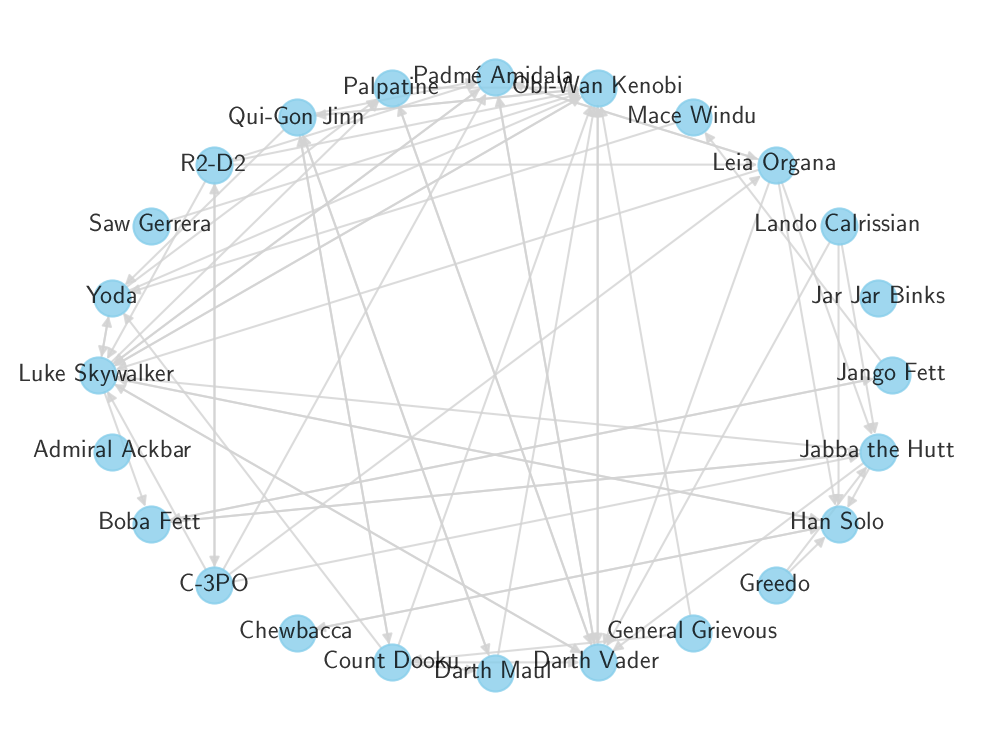

In [3]:
import matplotlib as plt
plt.rcParams['figure.dpi'] = 150

nodepos = nx.shell_layout(graph)
nx.draw(graph,pos=nodepos,with_labels = True,
        alpha=0.8,node_color="skyblue",edge_color="lightgray")

To implement PageRank we first build the Google Matrix

In [4]:
import numpy as np

nnodes           = graph.number_of_nodes() 
adjacency        = nx.to_numpy_array(graph)

#nans occur in case of absorbing node: division by 0
with np.errstate(divide='ignore',invalid='ignore'):
  row_stochastic   = adjacency / adjacency.sum(axis=1,keepdims=True)
  row_stochastic   = np.nan_to_num(row_stochastic,0.)


jump             = np.ones_like(row_stochastic) / nnodes

alpha            = 0.85
google           = (alpha * row_stochastic + (1-alpha) * jump )
#ensure stochasticity for absorbing nodes
google           = google / google.sum(axis=1,keepdims=True) 
#google matrix is eventually column stochastic
google = google.T

Now we implement the PageRank function that expects a column stochastic google matrix and a stopping criterion $\epsilon$

In [5]:
from numpy.linalg import norm
from numpy.random import random

def pagerank(G,eps=0.001):
	n,_ = G.shape
	x = random(n)
	x /= x.sum() 	                   #ensure probabilistic vector
	error = float('inf')
	idx = 0
	while error >= eps:
		xnext = G @ x
		error = norm(xnext-x)
		print(f'Iteration {idx}, Error = {error}')
		x     = xnext
		idx  += 1
	return x
	
pr = pagerank(google)

Iteration 0, Error = 0.1983531449433408
Iteration 1, Error = 0.09716321334669084
Iteration 2, Error = 0.04277680039430163
Iteration 3, Error = 0.024286747667087133
Iteration 4, Error = 0.01470224545596789
Iteration 5, Error = 0.00917617563503169
Iteration 6, Error = 0.006008859480682929
Iteration 7, Error = 0.003961619207231859
Iteration 8, Error = 0.0026420351672230536
Iteration 9, Error = 0.001751250080248675
Iteration 10, Error = 0.0011687418262660261
Iteration 11, Error = 0.0007764696216645119


It remains to match the PageRank scores with the node names and to display the results sorted by decreasing PageRank order:

In [6]:
for pr,nodename in sorted(zip(pr,graph.nodes),reverse=True):
	print(nodename,pr)

Luke Skywalker 0.15039028717790992
Darth Vader 0.12562502187701344
Obi-Wan Kenobi 0.12487137432800752
Han Solo 0.07500874028140869
Padmé Amidala 0.06837146062217052
Palpatine 0.06637802556766668
Qui-Gon Jinn 0.053347814246778764
Yoda 0.05201397171126624
Boba Fett 0.0432866314682319
Chewbacca 0.038837777673422974
Jabba the Hutt 0.036233077677382625
Leia Organa 0.02887512380615951
Jango Fett 0.02518708068782014
Darth Maul 0.018965801241613442
Count Dooku 0.018652819104113812
Mace Windu 0.01738791695304098
C-3PO 0.00810416559600728
R2-D2 0.008104165585362982
Saw Gerrera 0.006726457399103934
Lando Calrissian 0.006726457399103934
Jar Jar Binks 0.006726457399103934
Greedo 0.006726457399103934
General Grievous 0.006726457399103934
Admiral Ackbar 0.006726457399103934


## Final remarks

PageRank illustrates the potential of markov chains for modelling graph data.
In natural language processing, this kind of graph structure arises naturally in the context of social networks (facebook, twitter ...)
This kind of setup is not uncommon when strictly modelling language. 
Many language problems can be framed as graph or network problems. 
The most typical are lexical and semantic networks.

For large or very large graphs, at web scale,  the kind of implementation provided here is inappropriate.
Indeed the dense matrix has a size that grows quadratically with the number of nodes of the network and 
will inevitably cause both memory and run-time efficiency problems. 
Large social and semantic networks are small world networks and as such they are sparse networks. 
Actual implementations of large networks will rely on sparse matrices data structures with algorithms specialized for the case where most coefficients of the matrices are null.

Variants of the power iteration method are used in a variety of setups without necessarily running the markov chain till convergence.
This is the case of algorithms propagating information from node to node in a k-hop fashion. 
Label Propagation is a typical example in this family.

## Exercises

- Implement an algorithm that ranks the nodes of the Star Wars graph using the in-degree of each node. How are the results different from PageRank ?


- Suppose we have a graph of synonyms where nodes are word senses and edges represent the synonymy relation. 

   * Considering its adjacency matrix $\mathbf{A}$ and a one hot vector $\mathbf{x}$ selecting one particular word sense. 
     What mathematical operation will provide the synonym of the word sense selected by $\mathbf{x}$ ? What operation gets the synonyms of the synonyms ?
   * Does a markov chain using a stochastic adjacency matrix  of this graph  is likely to have absorbing nodes ? 
   * What does the PageRank of this graph would represent ?